In [1]:
import os
import glob
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl

import matplotlib as mpl

import plotting as putil
import dlc as dlc
import utils as util

import importlib

import sys
import shutil
import pickle
import datetime

import numpy as np
import class_reconstruct

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import zipfile

import cv2

In [2]:
putil.set_sns_style(style='white', min_fontsize=12)

In [3]:
%matplotlib notebook

In [4]:
#rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'
rootdir = '/Users/julianarhee/DeepLabCut'
# projectname = 'projector-1dot-jyr-2024-02-18'
projectname = '38mm-dyad-jyr-2024-02-23'
project_dir = os.path.join(rootdir, projectname) 
# load config file
cfg_fpath = os.path.join(project_dir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

In [6]:
minerva_base = '/Volumes/Julie/free-behavior-analysis/'
assay = '38mm-dyad'
analyzed_dir = os.path.join(minerva_base, assay, 'DeepLabCut', projectname)

analyzed_files = glob.glob(os.path.join(analyzed_dir, '*_el.h5'))
print('Found {} analyzed vids.'.format(len(analyzed_files)))

Found 25 analyzed vids.


In [7]:
# set output dir
#minerva_base = '/Volumes/Julie/free-behavior-analysis/38mm-dyad/DeepLabCut'
#savedir = os.path.join(minerva_base, 'DeepLabCut_{}'.format(projectname), 'visual_transformations') #'analyzed')
savedir = os.path.join(os.path.split(analyzed_dir)[0], 
                       'DeepLabCut_{}'.format(projectname), 'visual_transformations')
if not os.path.exists(savedir):
    os.makedirs(savedir)
print(savedir)

/Volumes/Julie/free-behavior-analysis/38mm-dyad/DeepLabCut/DeepLabCut_38mm-dyad-jyr-2024-02-23/visual_transformations


In [8]:
fps = 60  # Hz
max_jump=6
# ------------------------------
f1 = 'fly1'
f2 = 'fly2'
# ------------------------------

In [9]:
savedir

'/Volumes/Julie/free-behavior-analysis/38mm-dyad/DeepLabCut/DeepLabCut_38mm-dyad-jyr-2024-02-23/visual_transformations'

In [10]:
for fpath in analyzed_files:
    #fpath = analyzed_files[-3]
    data_id = os.path.split(fpath)[-1]
    sess_id = data_id.split('_gh')[0]
    sess_id = sess_id + '_gh' # '_'.join(sess_id.split('_')[0:-3])
    print(sess_id)
    if not os.path.exists(os.path.join(savedir, sess_id)):
        os.makedirs(os.path.join(savedir, sess_id))
    trk = pd.read_hdf(fpath) #os.path.join(pathname, filename))
    scorer = trk.columns.get_level_values(0)[0]
    tstamp = np.linspace(0, len(trk) * 1 / fps, len(trk))
    nframes = len(trk)

    fly1pos= trk.xs(f1, level='individuals', axis=1)
    fly2pos = trk.xs(f2, level='individuals', axis=1)
    # ifemale=0; imale=1;
    # ix=0; iy=1;
    ifly=0
    ihead=0; ibody=1; itail=2;
    pcutoff=0.99
    xy_list = []
    flybps = ['head', 'thorax', 'abdomentip']
    positions_male = dlc.dlc_to_multipos_array(fly1pos[scorer].copy(), bps=flybps, pcutoff=pcutoff)
    positions_female = dlc.dlc_to_multipos_array(fly2pos[scorer].copy(), bps=flybps, pcutoff=pcutoff)
    # compute relative position of female from male's head
    diff_positions = positions_female - positions_male[:,ihead,:][:,np.newaxis,:]
    num_frames = positions_male.shape[-1]

    S = class_reconstruct.ReconstructStimulusClass()

    female_widths = np.zeros((num_frames,))
    female_orientations = np.zeros((num_frames,))
    female_lateral_positions = np.zeros((num_frames,))
    for iframe in range(num_frames-1): 
#         if np.mod(iframe,10000) == 0:
#             print(iframe)
        female_widths[iframe], female_orientations[iframe], female_lateral_positions[iframe] = S.get_parameters_of_stripesmodel(positions_male[:,:,iframe].T, diff_positions[:,:,iframe].T)
    # also save stimulus params in struct
    P = {}
    P['female_widths'] = female_widths[:-1]   # ignore last frame b/c no predictants for it
    P['female_orientations'] = female_orientations[:-1]
    P['female_lateral_positions'] = female_lateral_positions[:-1]
    filename = os.path.join(savedir, '{:s}/stimulus_params_fly{:d}.pkl'.format(sess_id, ifly))
    pickle.dump(P, open(filename, 'wb'))

    # convert units
    bodylengths = dlc.get_bodypart_distance(fly1pos, 'head', 'abdomentip')
    fly_len_mm = 3 # mm
    fly_len_pixels = np.nanmean(bodylengths)
    mm_per_pix = fly_len_mm / fly_len_pixels
    # # load
    fly1df = dlc.load_trk_df(fpath, flyid=f1, fps=fps, max_jump=max_jump, cop_ix=None)
    fly2df = dlc.load_trk_df(fpath, flyid=f2, fps=fps, max_jump=max_jump, cop_ix=None)
    fly1df, fly2df = dlc.get_interfly_params(fly1df, fly2df, cop_ix=None)
    # convert units
    fly1df = dlc.convert_df_units(fly1df, mm_per_pix)
    female_lateral_positions = female_lateral_positions*-1

    fly1df['rel_lateral_pos'] = female_lateral_positions
    fly1df['rel_ang_size'] = female_widths
    fly1df['rel_ang_size_deg'] = np.rad2deg(female_widths)
    fly1df['rel_orientations'] = female_orientations
    fly1df['rel_orientations_deg'] = np.rad2deg(female_orientations)
    
    df_file = os.path.join(savedir,sess_id, 'flydf.pkl')
    pickle.dump(fly1df, open(df_file, 'wb'))

20240125-0956-fly1-yakWT_3do_sh_yakWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240118-1130-fly1-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1015-fly1-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20231223-1117_fly1_eleWT_5do_sh_eleWT_5do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1100-fly2-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240118-1425-fly3-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20231213-1122_fly2_eleWT_5do_sh_eleWT_5do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)


20240112-1500-fly4-yakWT_3do_sh_yakWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240122-1148-fly3-yakWT_3do_sh_yakWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20231227-1251_fly3_eleWT_5do_sh_eleWT_5do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240118-1415-fly2-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240112-1420-fly3-yakWT_3do_sh_yakWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240115-1015-fly1-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1523-fly4-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240119-1149-fly5-melWT_4do_sh_melWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240118-1425-fly3-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240115-1100-fly2-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1601-fly5-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1500-fly3-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240119-0932-fly1-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240119-0953-fly2-yakWT_3do_sh_yakWT_3do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240109-1039_fly1_eleWT_4do_sh_eleWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240116-1015-fly1-yakWT_4do_sh_yakWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


20240126-1023-fly2-melWT_4do_sh_melWT_4do_gh


/Users/julianarhee/Repositories/flytracker-analysis/class_reconstruct.py:202: RuntimeWarning: invalid value encountered in cast
  angle = np.round(angle).astype(int)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/Users/julianarhee/Repositories/flytracker-analysis/dlc.py:186: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


In [11]:
savedir

'/Volumes/Julie/free-behavior-analysis/38mm-dyad/DeepLabCut/DeepLabCut_38mm-dyad-jyr-2024-02-23/visual_transformations'

In [12]:
mm_per_pix

0.04509448945428772

In [14]:
acq

NameError: name 'acq' is not defined

In [15]:
local_dir = '/Users/julianarhee/Documents/rutalab/projects/courtship'
fname = 'courtship-free-behavior (Responses) - Form Responses 1.csv'
meta_fpath = os.path.join(local_dir, fname)
meta = pd.read_csv(meta_fpath)

In [16]:
meta['logfile']

0     20240112-0945-fly1-yakWT_3do_sh_yakWT_3do_gh
1     20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh
2     20240112-1420-fly3-yakWT_3do_sh_yakWT_3do_gh
3     20240112-1500-fly4-yakWT_3do_sh_yakWT_3do_gh
4     20240115-1015-fly1-melWT_3do_sh_melWT_3do_gh
5     20240115-1100-fly2-melWT_3do_sh_melWT_3do_gh
6     20240116-1015-fly1-yakWT_4do_sh_yakWT_4do_gh
7     20240116-1100-fly2-yakWT_4do_sh_yakWT_4do_gh
8     20240116-1500-fly3-yakWT_4do_sh_yakWT_4do_gh
9     20240116-1523-fly4-yakWT_4do_sh_yakWT_4do_gh
10    20240116-1601-fly5-yakWT_4do_sh_yakWT_4do_gh
11    20240116-1650-fly6-melWT_4do_sh_melWT_4do_gh
12    20240118-1130-fly1-melWT_3do_sh_melWT_3do_gh
13    20240118-1415-fly2-melWT_3do_sh_melWT_3do_gh
14    20240118-1425-fly3-melWT_3do_sh_melWT_3do_gh
15    20240119-0932-fly1-yakWT_4do_sh_yakWT_4do_gh
16    20240119-0953-fly2-yakWT_3do_sh_yakWT_3do_gh
17    20240119-1020-fly3-melWT_4do_sh_melWT_4do_gh
18    20240119-1107-fly4-melWT_4do_sh_melWT_4do_gh
19    20240119-1149-fly5-melWT_

In [17]:
meta.columns

Index(['Timestamp', 'assay', 'date', 'experimenter', 'room', 'temperature',
       'humidity', 'stimulus_protocol', 'incubator', 'fly_num', 'logfile',
       'species_male', 'genotype_male', 'dob_male', 'housing_male',
       'species_female', 'genotype_female', 'dob_female', 'housing_female',
       'courtship', 'copulation', 'FlyTracker: Is male ID == 1',
       'FlyTracker: copulation index', 'notes', 'Unnamed: 24'],
      dtype='object')

In [18]:
import pickle as pkl

In [19]:
cop_ele = {
    '20231213-1103_fly1_eleWT_5do_sh_eleWT_5do_gh': 52267,
    '20231213-1154_fly3_eleWT_6do_sh_eleWT_5do_gh': 17243,
    '20231214-1051_fly2_eleWT_3do_sh_eleWT_3do_gh': 61541,
    '20231223-1117_fly1_eleWT_5do_sh_eleWT_5do_gh': 55582,
    '20231226-1137_fly2_eleWT_4do_sh_eleWT_4do_gh': 13740,
    '20240105-1007_fly1_eleWT_3do_sh_eleWT_3do_gh': 5051, 
    '20240109-1039_fly1_eleWT_4do_sh_eleWT_4do_gh': 177300
}

In [20]:
jaaba_file = '/Volumes/Julie/free-behavior-analysis/38mm-dyad/jaaba.pkl'
with open(jaaba_file, 'rb') as f:
    jaaba = pkl.load(f)
jaaba.head()

,singing,chasing,orienting,courting,acquisition,age,species
0,0,0,0,0,20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh,2,melWT
1,0,0,0,0,20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh,2,melWT
2,0,0,0,0,20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh,2,melWT
3,0,0,0,0,20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh,2,melWT
4,0,0,0,0,20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh,2,melWT


In [21]:
df_fpaths = glob.glob(os.path.join(savedir, '20*', 'flydf.pkl'))
print(len(df_fpaths))


23


In [53]:
df_fpaths = glob.glob(os.path.join(savedir, '20*', 'flydf.pkl'))
print(len(df_fpaths))

d_list = []
for fp in df_fpaths:
    with open(fp, 'rb') as f:
        df_ = pkl.load(f)
    acq = os.path.split(os.path.split(fp)[0])[-1]
#     if acq not in jaaba['acquisition'].unique():
#         print(acq)
#         no_jaaba.append(acq)
#     acq = acq.split('sh')[0] + 'sh'
    df_['acquisition'] = acq #.split('gh')[0] + 'gh'
    #assert acq in meta['logfile'], "{} not found".format(acq)
    if 'ele' in acq:
        match_ = [v for v in cop_ele.keys() if v.startswith(acq)]
        if len(match_)==0:
            print("No match: {}".format(acq))
            cop_ix = np.nan
        else:
            cop_ix = cop_ele[match_[0]]
    else:
        match_ = [v for v in meta['logfile'] if v.startswith(acq)]
        assert len(match_)>0,  "{} not found".format(acq)
        #cop_ix = meta[meta['logfile']==match_[0]]['FlyTracker: copulation index']
        cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
    if np.isnan(cop_ix):
        cop_ix = len(df_)
    else:
        df_ = df_.loc[:int(cop_ix)]
    if 'yak' in acq:
        df_['species'] = 'Dyak'
    elif 'mel' in acq:
        df_['species'] = 'Dmel'
    else:
        df_['species'] = 'Dele'
    #j_ = jaaba[jaaba['acquisition']==acq].loc[:int(cop_ix)]
    #combi = pd.concat([df_, j_.drop(columns=['acquisition', 'age', 'species'])], axis=1)

    d_list.append(df_)
df0 = pd.concat(d_list)

23


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])


No match: 20231213-1122_fly2_eleWT_5do_sh_eleWT_5do_gh


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52

No match: 20231227-1251_fly3_eleWT_5do_sh_eleWT_5do_gh


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52264740.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cop_ix = float(meta.loc[meta['logfile']==match_[0], 'FlyTracker: copulation index'])
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_76518/52

In [54]:
dlc_file = '/Volumes/Julie/free-behavior-analysis/38mm-dyad/dlc.pkl'
with open(dlc_file, 'wb') as f:
    pkl.dump(df0, f) # = pkl.load(f)

In [58]:
df0[['acquisition', 'species']].drop_duplicates().groupby('species').count()

,acquisition
species,
Dele,4
Dmel,8
Dyak,11


# Load DLC-tracked flydf

In [59]:
dlc_file = '/Volumes/Julie/free-behavior-analysis/38mm-dyad/dlc_jaaba.pkl'
with open(dlc_file, 'rb') as f:
    df0 = pkl.load(f)

In [60]:
# No match: 20231213-1122_fly2_eleWT_5do_sh
# No match: 20231227-1251_fly3_eleWT_5do_sh

In [64]:
d_list = []
no_jaaba = []
for acq, df_ in df0[df0['species'].isin(['Dyak', 'Dmel'])].groupby('acquisition'):
    last_ix = df_.iloc[-1].name
    if acq not in jaaba['acquisition'].unique():
        no_jaaba.append(acq)
        continue
    j_ = jaaba[jaaba['acquisition']==acq].loc[:last_ix]
    assert j_.shape[0] ==  df_.shape[0], "Bad match: {}".format(acq)
    df_ = pd.concat([df_, j_.drop(columns=['species', 'acquisition', 'age'])], axis=1)
    d_list.append(df_)

fulldf = pd.concat(d_list)

In [63]:
# fulldf = df0.copy() #.columns

#### split into bout

In [42]:
curr_species = ['Dele', 'Dmau', 'Dmel', 'Dsant', 'Dyak']

species_cmap = sns.color_palette('colorblind', n_colors=len(curr_species))
print(curr_species)
species_palette = dict((sp, col) for sp, col in zip(curr_species, species_cmap))

['Dele', 'Dmau', 'Dmel', 'Dsant', 'Dyak']


In [43]:
d_list = []
for acq, df_ in fulldf.groupby('acquisition'):
    df_ = util.mat_split_courtship_bouts(df_, bout_marker='courting')
    dur_ = util.get_bout_durs(df_, bout_varname='boutnum', return_as_df=True,
                    timevar='time')
    d_list.append(df_.merge(dur_, on=['boutnum']))
jfly = pd.concat(d_list)

In [44]:
jfly['orienting_only'] = 0
jfly.loc[(jfly['courting']==1) & (jfly['singing']==0) & (jfly['chasing']==0), \
         'orienting_only'] = 1
jfly['chasing_only'] = 0
jfly.loc[(jfly['courting']==1) & (jfly['singing']==0), \
         'chasing_only'] = 1

##### get means

In [45]:
meandf = jfly.groupby(['acquisition', 'species', 'boutnum' ]).mean().reset_index()
# meandf
min_boutdur = 1
plotdf = meandf[meandf['boutdur']>=min_boutdur].copy()

<IPython.core.display.Javascript object>


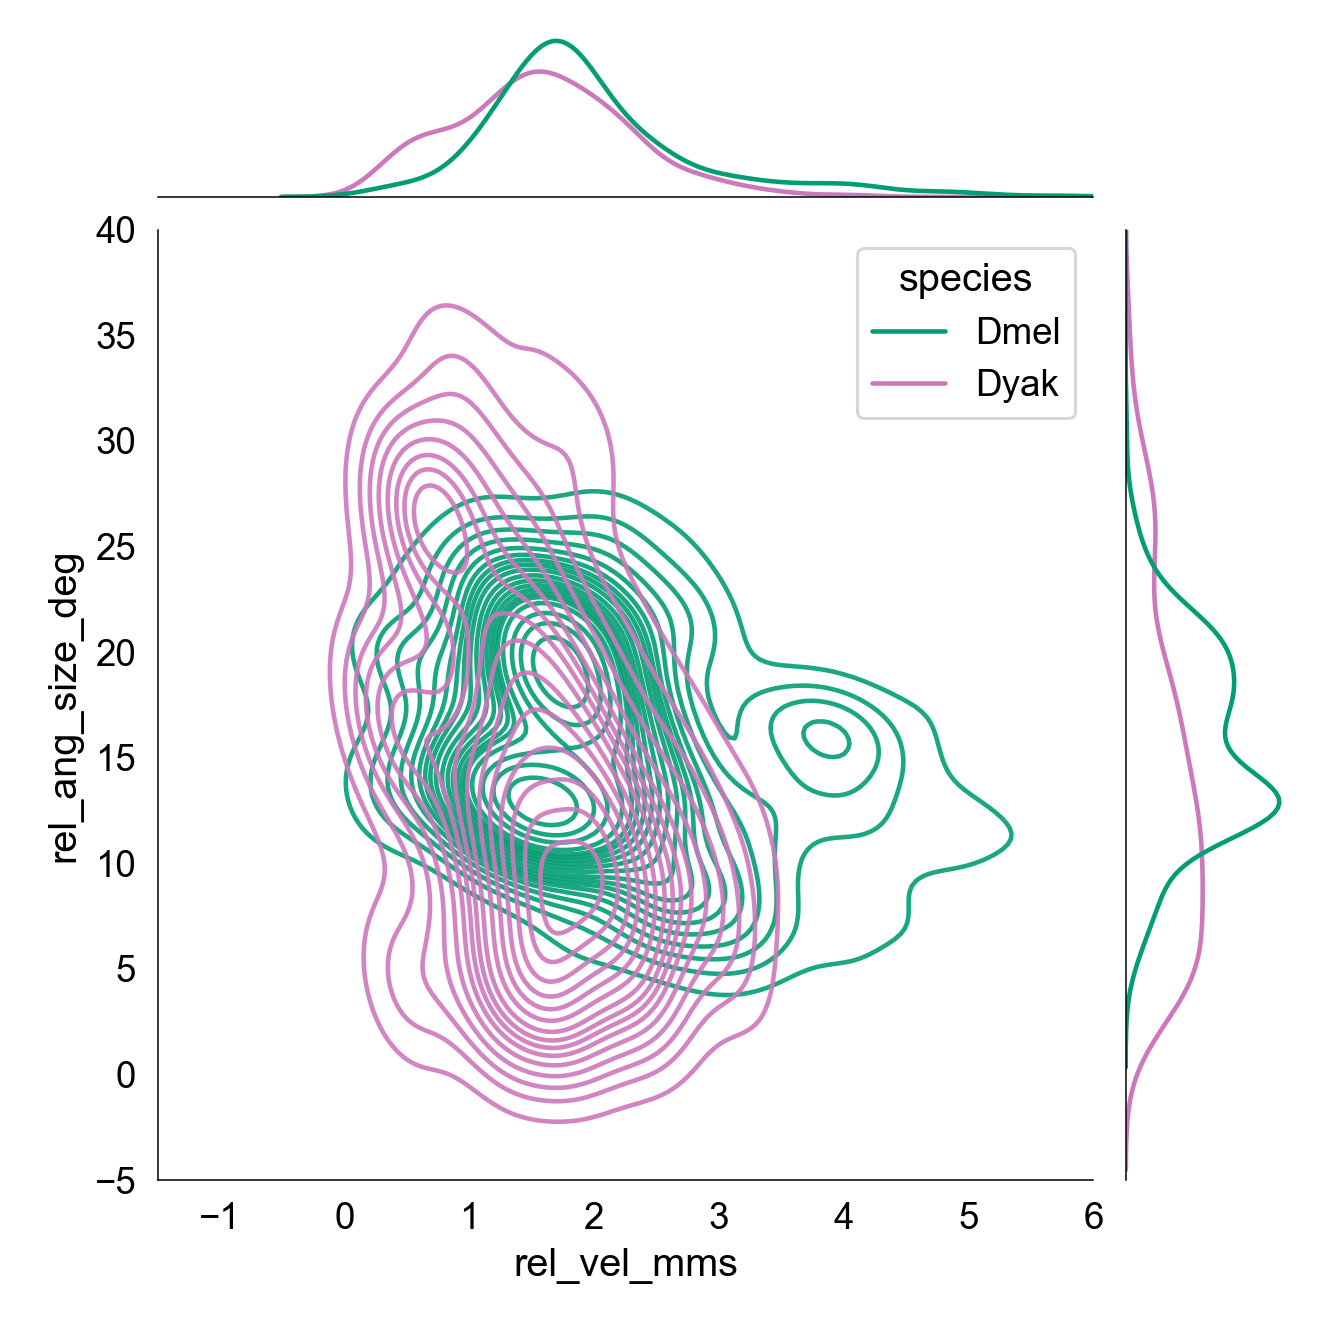

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


(-5.0, 40.0)

In [126]:
g = sns.jointplot(data=plotdf[plotdf[varname]>0].reset_index(drop=True), x=x, y=y, 
            hue='species', palette=species_palette, #palette=species_cdict,
          kind='kde', joint_kws={'s': 10, 'alpha': 0.9, 'n_levels': 20})
pl.xlim([-1.5, 6])
pl.ylim([-5, 40])

In [129]:
putil.set_sns_style(style='white', min_fontsize=18)

singing


<IPython.core.display.Javascript object>


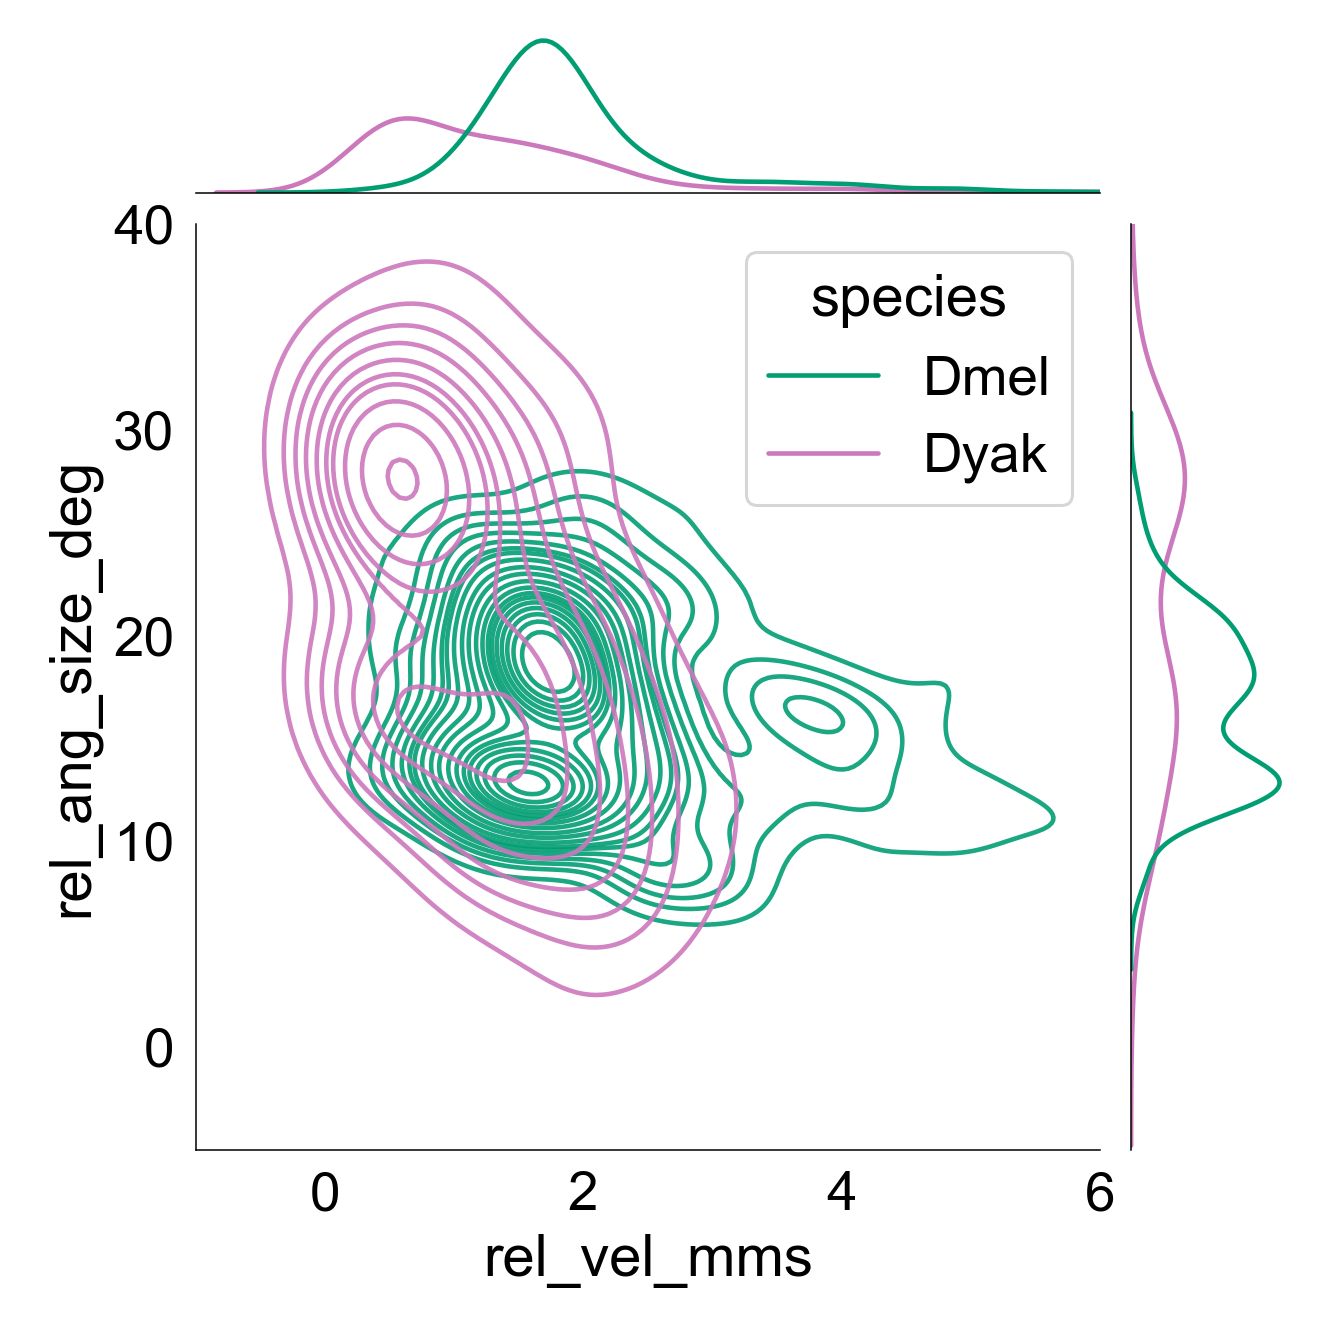

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(



courting


<IPython.core.display.Javascript object>


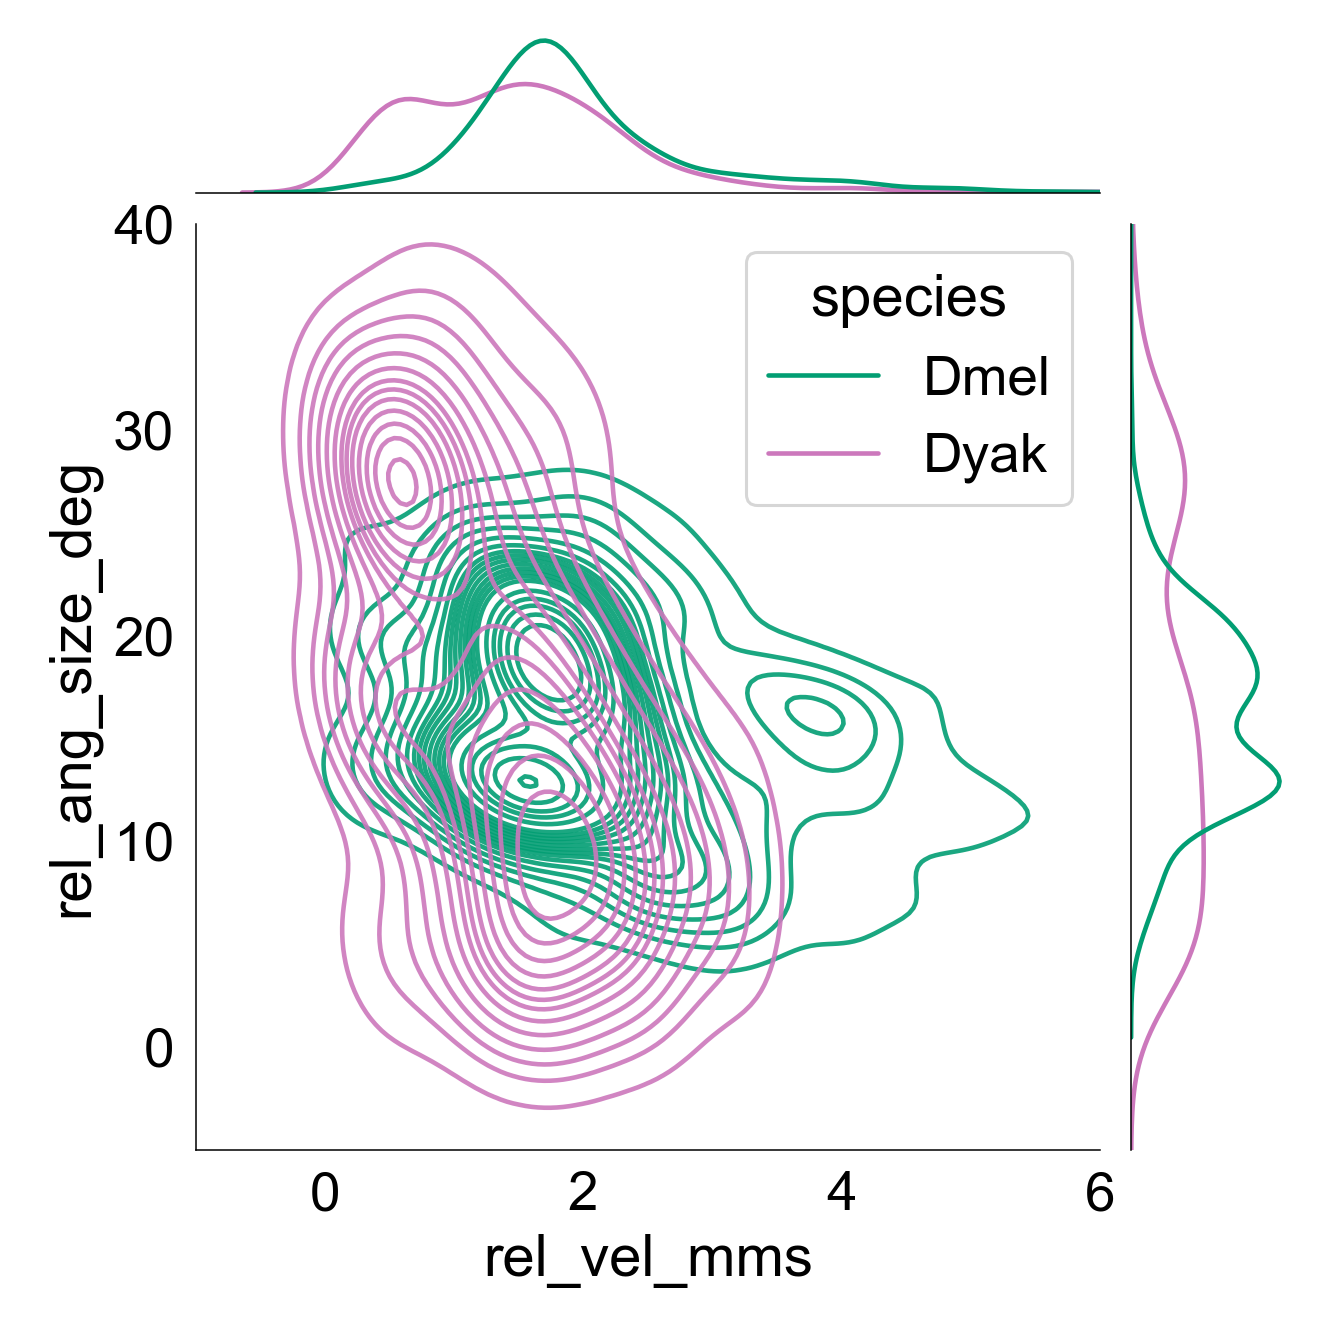

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(



chasing_only


<IPython.core.display.Javascript object>


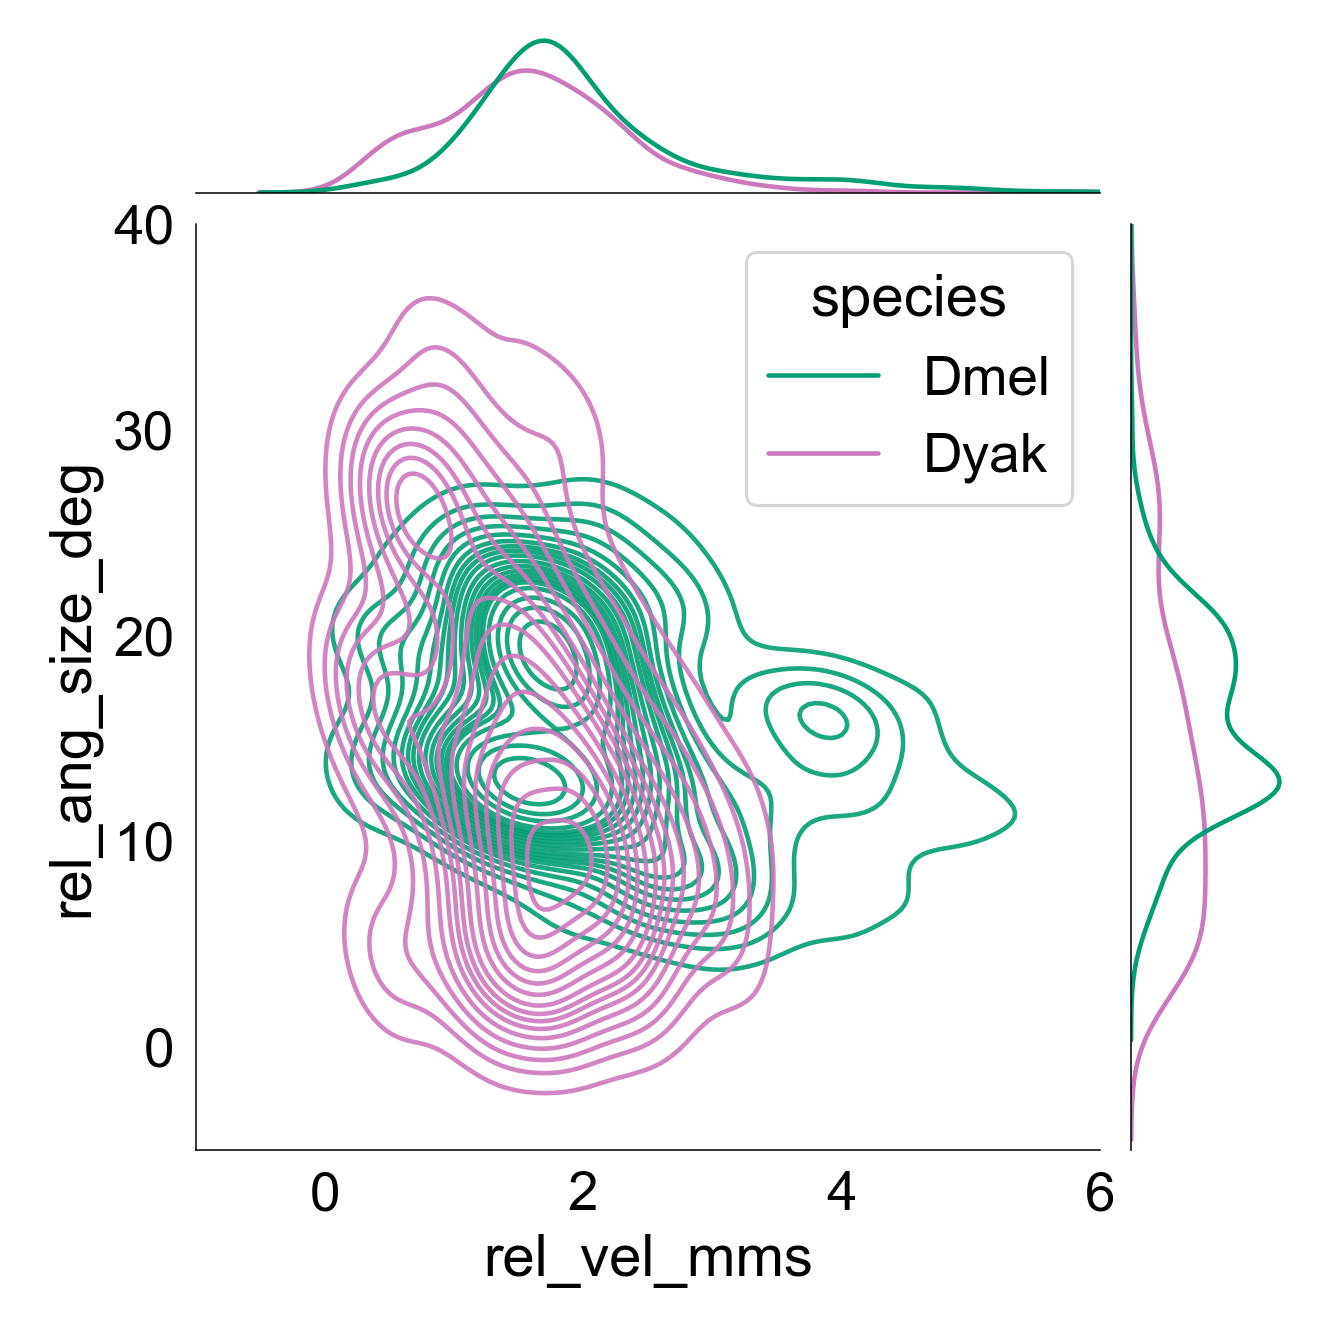

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(



orienting_only


<IPython.core.display.Javascript object>


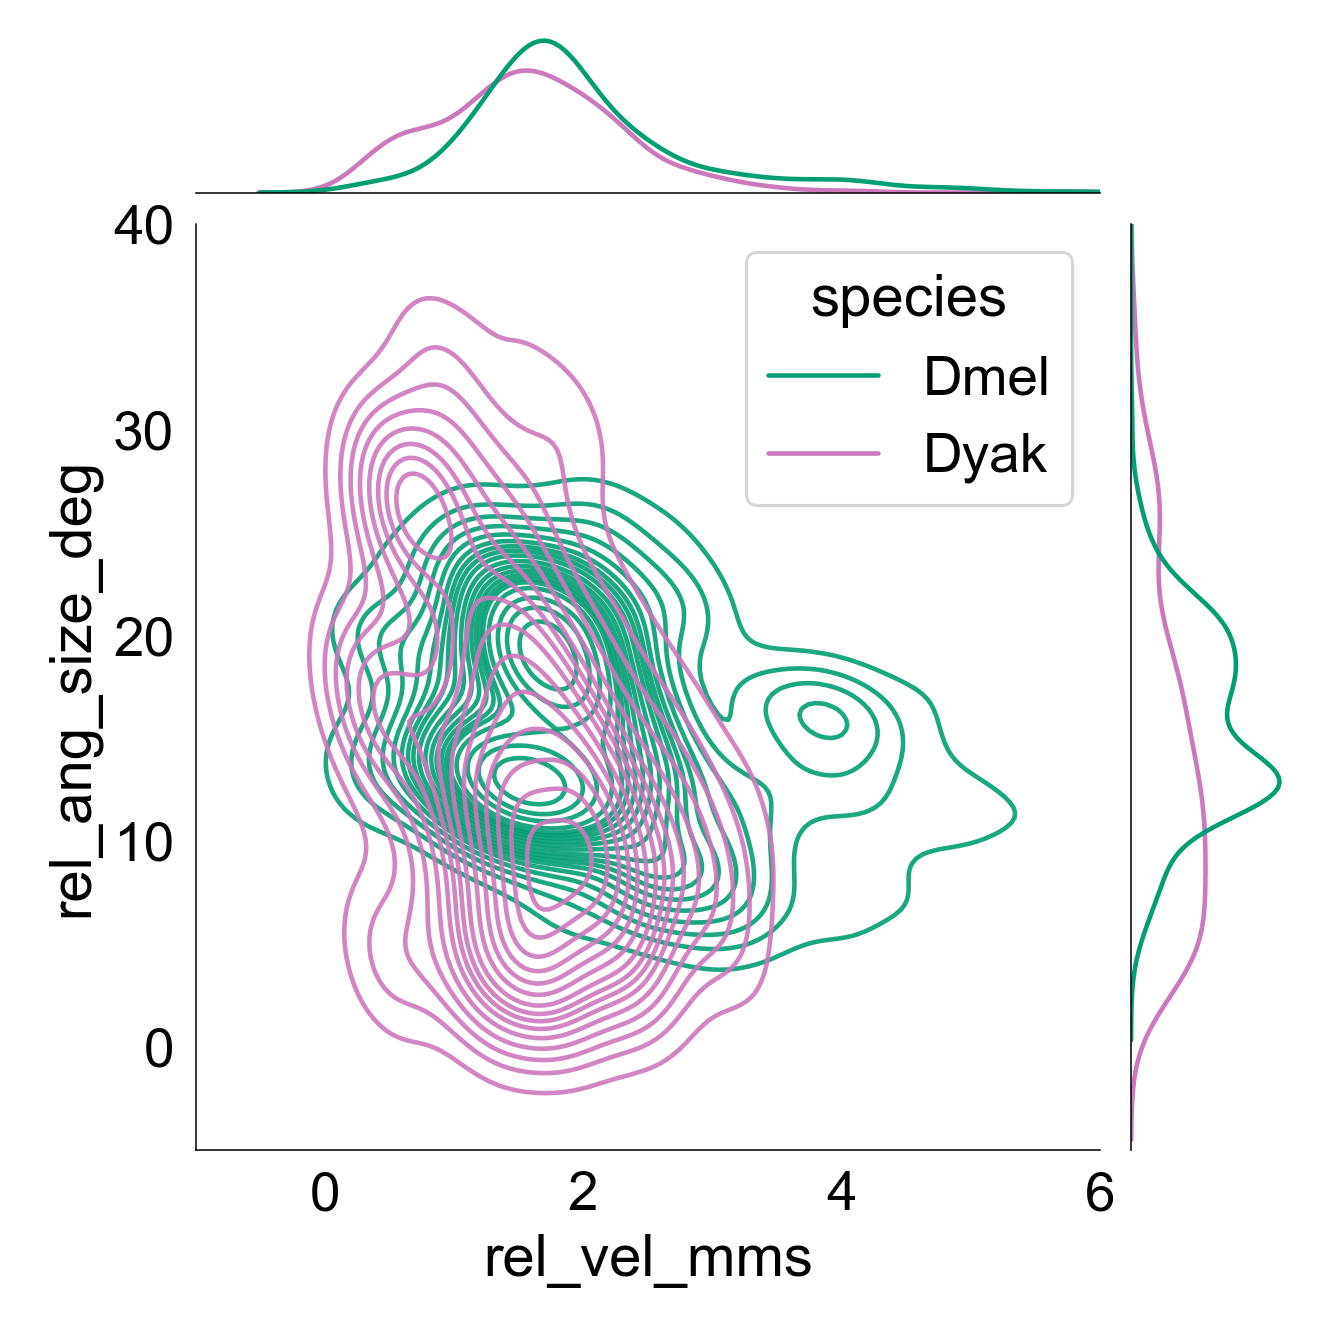

/Users/julianarhee/miniforge3/envs/flytracker/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(


In [130]:
y='rel_ang_size_deg'
x='rel_vel_mms' #''lin_speed' 
for varname in ['singing', 'courting', 'chasing_only', 'orienting_only']:
    print(varname)
    g = sns.jointplot(data=plotdf[plotdf[varname]>0].reset_index(drop=True), x=x, y=y, 
            hue='species', palette=species_palette, #palette=species_cdict,
          kind='kde', joint_kws={'s': 10, 'alpha': 0.9, 'n_levels': 20})
    pl.xlim([-1, 6])
    pl.ylim([-5, 40])
    figname = 'jnt_{}_{}-v-{}_all-frames'.format(varname, x, y)
    pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
    pl.savefig(os.path.join(savedir, '{}.svg'.format(figname)))
    print()

In [121]:
savedir

'/Volumes/Julie/free-behavior-analysis/38mm-dyad/DeepLabCut/DeepLabCut_38mm-dyad-jyr-2024-02-23/visual_transformations'

In [154]:
meandf['dist_to_other_mm'].max()

37.434524155707685

In [ ]:
meandf['dist_to_other_mm']

In [260]:
q = 5
bin_labels = np.arange(0, q)

# bins = [0, 4, 7, 11, 40]
bins = [0, 5, 10, 15, 40]
bin_labels = ['4', '7', '11', '>12']
meandf['dist_to_other_mm'] = meandf['dist_to_other']*0.04
meandf['dist_quartile'] = pd.cut(meandf['dist_to_other_mm'], bins=bins) #q=q) #bins=q)
meandf['dist_bin'] = pd.cut(meandf['dist_to_other_mm'], bins=bins, labels=bin_labels) #, precision=0)

# meandf['dist_quartile'] = pd.cut(meandf['dist_to_other_mm'], bins=q) #bins=q)
# meandf['dist_bin'] = pd.cut(meandf['dist_to_other'], bins=q, labels=bin_labels, precision=0)

meandf['dist_bin_left'] = [v.left if isinstance(v, pd.Interval) else None for v in meandf['dist_quartile']]
meandf['dist_bin_right'] = [v.right if isinstance(v, pd.Interval) else None for v in meandf['dist_quartile']]

<IPython.core.display.Javascript object>


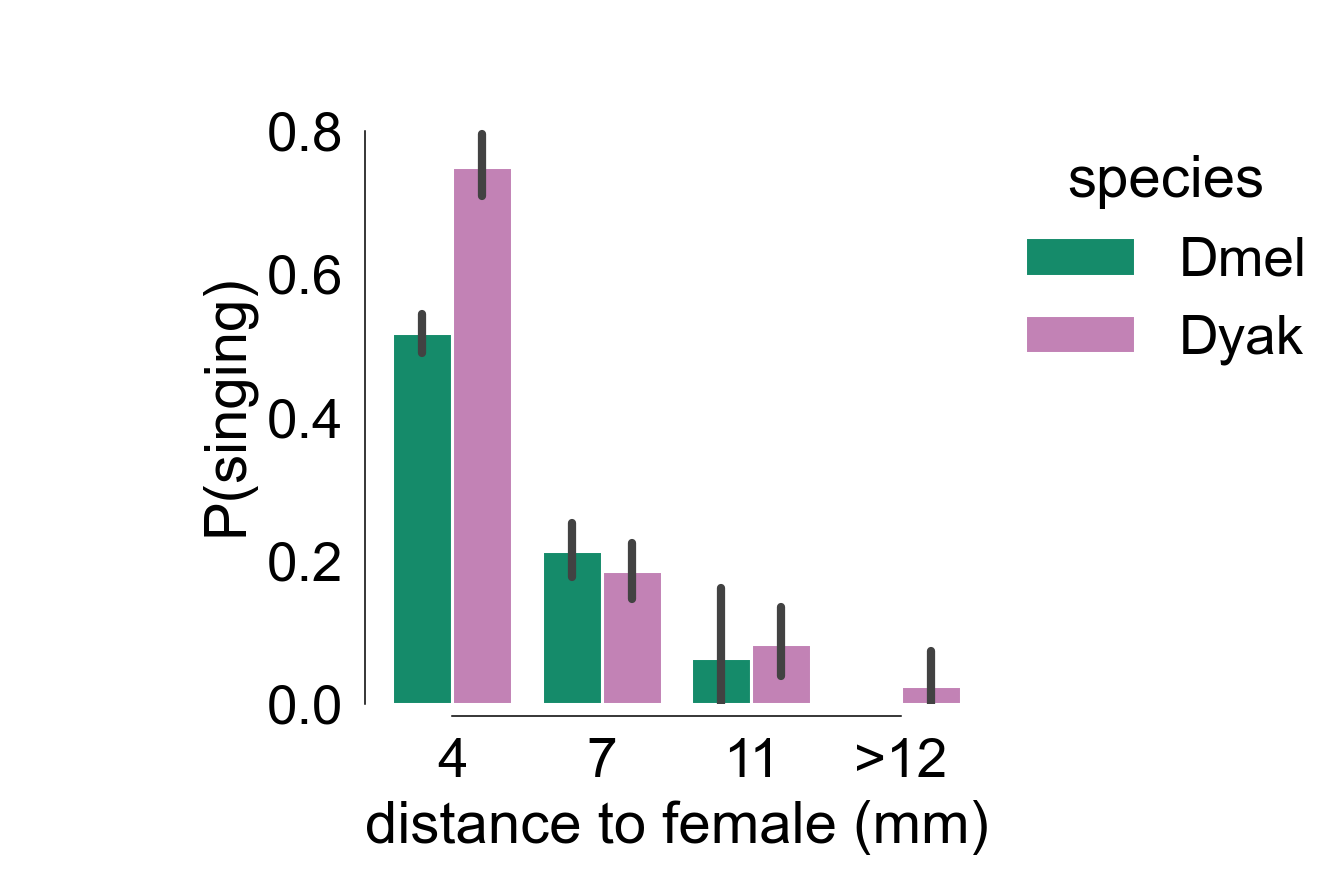

In [261]:
from matplotlib.ticker import FormatStrFormatter
plotdf = meandf[(meandf['courting']>0) & (meandf['boutdur']>=1) ].copy()

fig, ax =pl.subplots()
sns.barplot(data=plotdf, x='dist_bin', y='singing', hue='species', 
            palette=species_palette, ax=ax)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax.set_box_aspect(1)
# xvs = [round(v, 0) for v in sorted(meandf['dist_bin_left'].unique())][:-1]
# ax.set_xticklabels(xvs)
ax.set_xlabel('distance to female (mm)')
ax.set_ylabel('P(singing)')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
pl.subplots_adjust(bottom=0.2)
sns.despine(offset=4, trim=True)

figname = 'pSong_v_dist_yak-v-mel'
pl.savefig(os.path.join(savedir, '{}.png'.format(figname)))
pl.savefig(os.path.join(savedir, '{}.svg'.format(figname)))


## dlc df

In [67]:
d_list = []
for acq, df_ in df0.groupby('acquisition'):
    print(acq)
    #df_ = util.mat_split_courtship_bouts(df_, bout_marker='courting')
#     dur_ = util.get_bout_durs(df_, bout_varname='boutnum', return_as_df=True,
#                     timevar='time')
    d_list.append(df_.merge(dur_, on=['boutnum']))
dlcdf = pd.concat(d_list)

20231213-1122_fly2_eleWT_5do_sh_eleWT_5do_gh
20231223-1117_fly1_eleWT_5do_sh_eleWT_5do_gh
20231227-1251_fly3_eleWT_5do_sh_eleWT_5do_gh
20240109-1039_fly1_eleWT_4do_sh_eleWT_4do_gh
20240112-1030-fly2-melWT_3do_sh_melWT_3do_gh
20240112-1420-fly3-yakWT_3do_sh_yakWT_3do_gh
20240112-1500-fly4-yakWT_3do_sh_yakWT_3do_gh
20240115-1015-fly1-melWT_3do_sh_melWT_3do_gh
20240115-1100-fly2-melWT_3do_sh_melWT_3do_gh
20240116-1015-fly1-yakWT_4do_sh_yakWT_4do_gh
20240116-1100-fly2-yakWT_4do_sh_yakWT_4do_gh
20240116-1500-fly3-yakWT_4do_sh_yakWT_4do_gh
20240116-1523-fly4-yakWT_4do_sh_yakWT_4do_gh
20240116-1601-fly5-yakWT_4do_sh_yakWT_4do_gh
20240118-1130-fly1-melWT_3do_sh_melWT_3do_gh
20240118-1415-fly2-melWT_3do_sh_melWT_3do_gh
20240118-1425-fly3-melWT_3do_sh_melWT_3do_gh
20240119-0932-fly1-yakWT_4do_sh_yakWT_4do_gh
20240119-0953-fly2-yakWT_3do_sh_yakWT_3do_gh
20240119-1149-fly5-melWT_4do_sh_melWT_4do_gh
20240122-1148-fly3-yakWT_3do_sh_yakWT_3do_gh
20240125-0956-fly1-yakWT_3do_sh_yakWT_3do_gh
20240126-1

In [68]:
# dlcmean = df0.groupby(['acquisition', 'species', 'boutnum' ]).mean().reset_index()

In [74]:
# dlcmean[dlcmean['boutdur']>=min_boutdur]['species'].unique()

array(['Dmel', 'Dyak'], dtype=object)

In [72]:
# min_boutdur = 1
# plotdf = dlcmean[dlcmean['boutdur']>=min_boutdur].copy()

In [78]:
df0.columns

Index(['heading', 'centroid_x', 'centroid_y', 'lin_speed', 'left_wing_angle',
       'right_wing_angle', 'inter_wing_dist', 'time', 'dist_to_other',
       'facing_angle', 'ang_between', 'dist_to_other_mm', 'lin_speed_mms',
       'dist_to_other_mm_diff', 'time_diff', 'rel_vel_mms', 'rel_lateral_pos',
       'rel_ang_size', 'rel_ang_size_deg', 'rel_orientations',
       'rel_orientations_deg', 'acquisition', 'species', 'singing', 'chasing',
       'orienting', 'courting'],
      dtype='object')

In [86]:
df0['left_wing_angle_abs'] = df0['left_wing_angle'].abs()
df0['facing_angle_abs'] = df0['facing_angle'].abs() #.min(), df0['facing_angle'].max()

In [107]:
min_wing_ang = np.deg2rad(30)
max_facing_angle = np.deg2rad(180)

plotdf = df0[(df0['left_wing_angle_abs']>=min_wing_ang)] 
#             & (df0['facing_angle']) <= max_facing_angle].copy()
# plotdf['rel_orientations_abs'] = plotdf['rel_orientations'].abs()

<IPython.core.display.Javascript object>


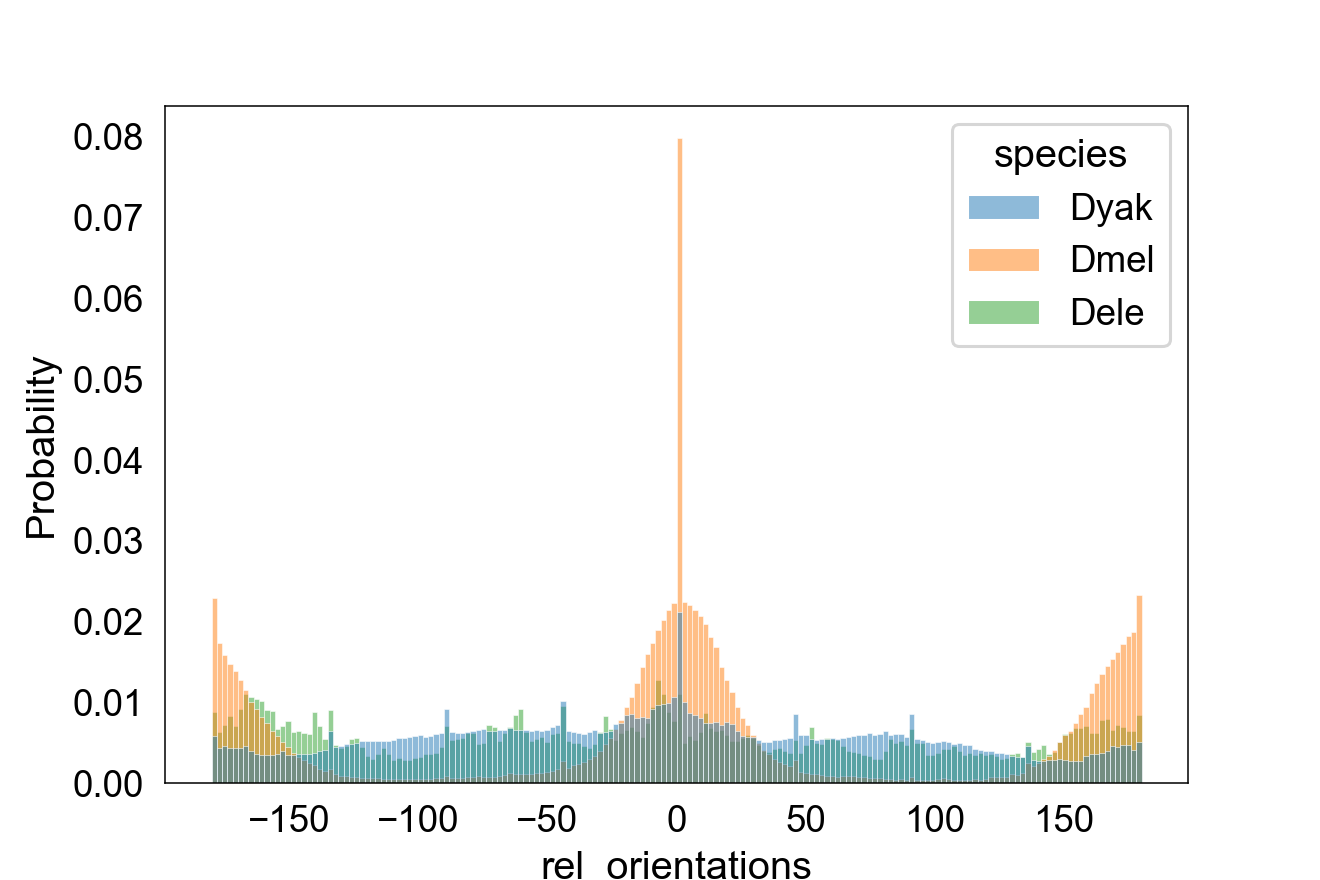

<Axes: xlabel='rel_orientations', ylabel='Probability'>

In [108]:
fig, ax = pl.subplots()
sns.histplot(data=plotdf, ax=ax,
             x='rel_orientations', hue='species', 
             common_norm=False, stat='probability')
         


In [ ]:
def calculate_velocity(positions_over_time, time_var='time'):
    movements_over_timesteps = (
        np.roll(positions_over_time, -1, axis=0)
        - positions_over_time)[:-1]

    speeds = np.sqrt(
        movements_over_timesteps.x ** 2 +
        movements_over_timesteps.y ** 2
    ) / movements_over_timesteps[time]

    return pd.DataFrame({
        time: positions_over_time[time][:-1],
        'vel': speeds,
    })

In [ ]:
import math

class Vector:
    def __init__(self, x, y):
        self.x = x
        self.y = y

v1 = Vector(0, 1)
v2 = Vector(0, -1)

v1_theta = math.atan2(v1.y, v1.x)
v2_theta = math.atan2(v2.y, v2.x)

r = (v2_theta - v1_theta) * (180.0 / math.pi)

if r < 0:
    r += 360.0

print r # r % 360 